In [342]:
import sklearn
import pandas as pd
import numpy as np

In [343]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, cohen_kappa_score
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression

In [344]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
df = pd.DataFrame(ha)
df['cp'] = df['cp'].astype('object')
df['restecg'] = df['restecg'].astype('object')
df['output'].astype(int)
df.head(3)

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1


# Part One: Fitting Models

In [345]:
#Universal Column Transformer

ct = ColumnTransformer(
    [("dm", OneHotEncoder(sparse_output = False, handle_unknown = 'ignore'),
      make_column_selector(dtype_include = object)),
     ("st", StandardScaler(), 
      make_column_selector(dtype_include = np.number))], 
    remainder = "drop"
).set_output(transform = "pandas")

In [346]:
#KNN Model Tuning

def tune_knn(model, k):

    X = df[model]
    y = df['output']
    
    knn_pipeline = Pipeline(
    [("preprocessing", ct),
     ("knn", KNeighborsClassifier(n_neighbors = k))])
    
    y_pred_cv = cross_val_predict(knn_pipeline, X, y, cv = 5, method = 'predict_proba')[:, 1]
    fpr, tpr, _ = roc_curve(y, y_pred_cv)
    roc_auc = auc(fpr, tpr)
    
    return roc_auc

model1 = ['age', 'sex', 'cp', 'trtbps', 'chol', 'restecg', 'thalach']
model2 = ['age', 'sex', 'cp', 'trtbps', 'chol', 'thalach']
model3 = ['age', 'sex', 'cp', 'trtbps', 'thalach']
models = {'Model 1': model1, 'Model 2': model2, 'Model 3': model3}
k_values = [20, 40, 60]

columns = ['Model', 'K', 'Roc-Auc']
tune_df = pd.DataFrame(columns = columns)
for name, model in models.items():
    for k in k_values:
        roc_auc = tune_knn(model, k)
        row = {'Model': name, 'K': k, 'Roc-Auc': roc_auc}
        row = pd.DataFrame([row])
        tune_df = pd.concat([tune_df, row], ignore_index = True)
        
tune_df

,Model,K,Roc-Auc
0,Model 1,20,0.831005
1,Model 1,40,0.836641
2,Model 1,60,0.847940
3,Model 2,20,0.829118
4,Model 2,40,0.847374
5,Model 2,60,0.843949
6,Model 3,20,0.841198
7,Model 3,40,0.847320
8,Model 3,60,0.845459


In [347]:
#KNN Model Fit (Model 3; K = 40)

X = df[['age', 'sex', 'cp', 'trtbps', 'thalach']]
y = df['output']
    
knn_pipeline = Pipeline(
    [("preprocessing", ct),
     ("knn", KNeighborsClassifier(n_neighbors = 40))])

knn_pipeline.fit(X, y)
y_pred = knn_pipeline.predict(X)    
matrix = confusion_matrix(y, y_pred)
matrix

array([[ 96,  31],
       [ 30, 116]])

In [348]:
#Logistic Model Tuning

def tune_log(model, penalty):

    X = df[model]
    y = df['output']
    
    log_pipeline = Pipeline(
        [("preprocessing", ct),
         ("log", LogisticRegression(penalty = penalty))])
    
    y_pred_cv = cross_val_predict(log_pipeline, X, y, cv = 5, method = 'predict_proba')[:, 1]
    fpr, tpr, _ = roc_curve(y, y_pred_cv)
    roc_auc = auc(fpr, tpr)
        
    return roc_auc

model1 = ['age', 'sex', 'cp', 'trtbps', 'chol', 'restecg', 'thalach']
model2 = ['age', 'sex', 'cp', 'trtbps', 'chol', 'thalach']
model3 = ['age', 'sex', 'cp', 'trtbps', 'thalach']
model4 = ['sex', 'cp', 'trtbps', 'chol', 'restecg', 'thalach']
models = {'Model 1': model1, 'Model 2': model2, 'Model 3': model3, 'Model 4': model4}
penalties = [None, 'l2']

columns = ['Model', 'Penalty', 'Roc-Auc']
tune_df = pd.DataFrame(columns = columns)
for name, model in models.items():
    for pen in penalties:
        roc_auc = tune_log(model, pen)
        row = {'Model': name, 'Penalty': pen, 'Roc-Auc': roc_auc}
        row = pd.DataFrame([row])
        tune_df = pd.concat([tune_df, row], ignore_index = True)
        
tune_df

,Model,Penalty,Roc-Auc
0,Model 1,None,0.854439
1,Model 1,l2,0.860047
2,Model 2,None,0.864793
3,Model 2,l2,0.866465
4,Model 3,None,0.858699
5,Model 3,l2,0.860695
6,Model 4,None,0.853791
7,Model 4,l2,0.860641


In [349]:
#Logistic Model Fit (Model 2; Penalty = 'l2')

X = df[['age', 'sex', 'cp', 'trtbps', 'chol', 'thalach']]
y = df['output']
    
log_pipeline = Pipeline(
    [("preprocessing", ct),
     ("log", LogisticRegression(penalty = 'l2'))])

log_pipeline.fit(X, y)
y_pred = log_pipeline.predict(X)    
matrix = confusion_matrix(y, y_pred)
matrix

array([[ 95,  32],
       [ 24, 122]])

In [350]:
#Decision Tree Model Tuning

def tune_dt(model, alpha):

    X = df[model]
    y = df['output']
    
    dt_pipeline = Pipeline(
    [("preprocessing", ct),
     ("dt", DecisionTreeClassifier(ccp_alpha = alpha))])  
    
    y_pred_cv = cross_val_predict(dt_pipeline, X, y, cv = 5, method = 'predict_proba')[:, 1]
    fpr, tpr, _ = roc_curve(y, y_pred_cv)
    roc_auc = auc(fpr, tpr)
    
    return roc_auc

model1 = ['age', 'sex', 'cp', 'trtbps', 'chol', 'restecg', 'thalach']
model2 = ['age', 'sex', 'cp', 'trtbps']
model3 = ['age', 'sex', 'cp']
models = {'Model 1': model1, 'Model 2': model2, 'Model 3': model3}
alpha_values = [0.01, 0.02, 0.03]

columns = ['Model', 'Alpha', 'Roc-Auc']
tune_df = pd.DataFrame(columns = columns)
for name, model in models.items():
    for alpha in alpha_values:
        roc_auc = tune_dt(model, alpha)
        row = {'Model': name, 'Alpha': alpha, 'Roc-Auc': roc_auc}
        row = pd.DataFrame([row])
        tune_df = pd.concat([tune_df, row], ignore_index = True)
        
tune_df

,Model,Alpha,Roc-Auc
0,Model 1,0.01,0.747007
1,Model 1,0.02,0.761622
2,Model 1,0.03,0.745227
3,Model 2,0.01,0.787536
4,Model 2,0.02,0.765344
5,Model 2,0.03,0.745227
6,Model 3,0.01,0.789990
7,Model 3,0.02,0.773029
8,Model 3,0.03,0.745227


In [351]:
#Decision Tree Model Fit (Model 3; Alpha = 0.02)

X = df[['age', 'sex', 'cp']]
y = df['output']
    
dt_pipeline = Pipeline(
    [("preprocessing", ct),
     ("dt", DecisionTreeClassifier(ccp_alpha = 0.02))])  

dt_pipeline.fit(X, y)
y_pred = dt_pipeline.predict(X)    
matrix = confusion_matrix(y, y_pred)
matrix

array([[114,  13],
       [ 47,  99]])

#Interpretation:

The "best" model across all three classification methods included the variables 'age', 'sex, and 'cp', indicating that they are the strongest predictor variables. Some models utilized the 'trtbps', 'chol', and 'thalach' variables, meaning that they hold some value. The 'restecg' variable was the only unused predictor meaning that it can most likely be discarded from analysis. 

The tuning process for the Decision Tree model proved to be the most insightful for the usefulness of the predictors. During the tuning process, removing variables: 'trtbps', 'chol', 'restecg', thalach' from the model had little to no impact on the ROC-AUC value, compared to the full model. Conversely, removing variables 'age', 'sex', 'cp' from the model strongly decreased the ROC-AUC value. Fittingly, our strongest DT model only included the three most important variables.

In [352]:
#Roc Curve Plot DataFrame

X_knn = df[['age', 'sex', 'cp', 'trtbps', 'thalach']]
X_log = df[['age', 'sex', 'cp', 'trtbps', 'chol', 'thalach']]
X_dt = df[['age', 'sex', 'cp']]
y = df['output']

knn_pipeline = Pipeline(
    [("preprocessing", ct),
     ("knn", KNeighborsClassifier(n_neighbors = 40))])

log_pipeline = Pipeline(
    [("preprocessing", ct),
     ("log", LogisticRegression(penalty = 'l2'))])

dt_pipeline = Pipeline(
    [("preprocessing", ct),
     ("dt", DecisionTreeClassifier(ccp_alpha = 0.02))])

pipelines = {'KNN': knn_pipeline, 'Log': log_pipeline, 'DT': dt_pipeline}

columns = ['Model', 'FPR', 'TPR']
roc_df = pd.DataFrame(columns = columns)
for name, pipeline in pipelines.items():
    if name == 'KNN':
        y_pred_cv = cross_val_predict(pipeline, X_knn, y, cv = 5, method = 'predict_proba')[:, 1]
    elif name == 'Log':
        y_pred_cv = cross_val_predict(pipeline, X_log, y, cv = 5, method = 'predict_proba')[:, 1]
    elif name == 'DT':
        y_pred_cv = cross_val_predict(pipeline, X_dt, y, cv = 5, method = 'predict_proba')[:, 1]
        
    fpr, tpr, _ = roc_curve(y, y_pred_cv)
    ind_df = pd.DataFrame({'Model': name, 'FPR': fpr, 'TPR': tpr})
    roc_df = pd.concat([roc_df, ind_df], ignore_index = True)

roc_df

,Model,FPR,TPR
0,KNN,0.000000,0.000000
1,KNN,0.000000,0.006849
2,KNN,0.000000,0.027397
3,KNN,0.000000,0.054795
4,KNN,0.000000,0.095890
...,...,...,...
138,DT,0.582677,0.856164
139,DT,0.716535,0.904110
140,DT,0.866142,0.958904
141,DT,0.992126,0.986301


In [353]:
from plotnine import ggplot, aes, geom_point, geom_line, geom_histogram, geom_bar, labs, geom_smooth, facet_wrap
from plotnine import guide_legend, ggtitle, theme_minimal, guides, element_text, scale_color_manual, geom_abline

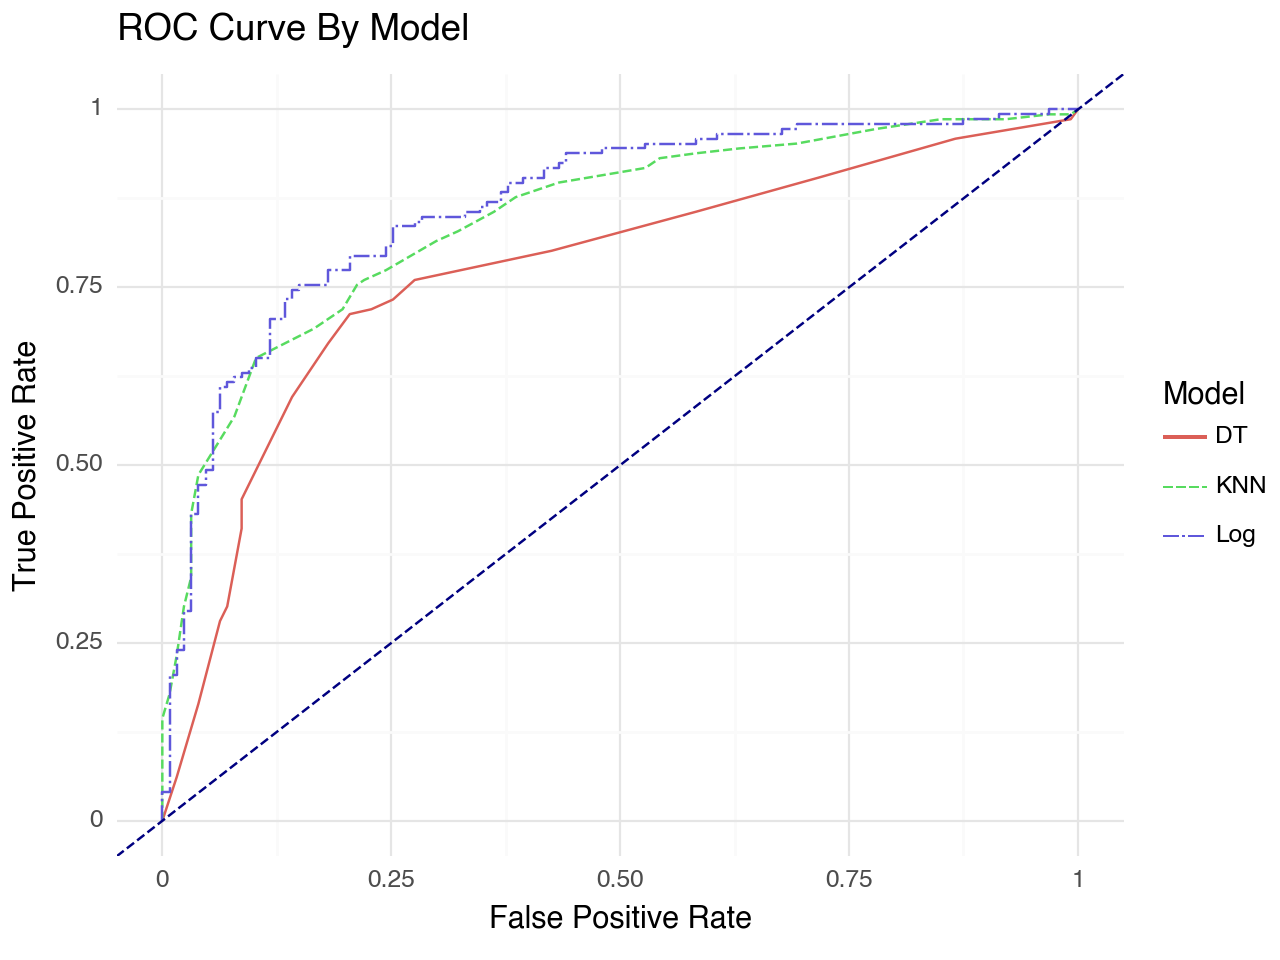

<Figure Size: (640 x 480)>

In [354]:
#Roc Curve Plotting

(ggplot(roc_df, aes(x = 'FPR', y = 'TPR'))
+ geom_line(aes(color = 'Model', linetype = 'Model'))
+ geom_abline(intercept = 0, slope = 1, linetype = '--', color = 'navy')
+ labs(title = f'ROC Curve By Model', x = 'False Positive Rate', y = 'True Positive Rate')
+ theme_minimal()
#+ facet_wrap('Model')
)

# Part Two: Metrics

In [355]:
#Metrics Function

knn_pipeline = Pipeline(
    [("preprocessing", ct),
     ("knn", KNeighborsClassifier(n_neighbors = 40))])
    
log_pipeline = Pipeline(
    [("preprocessing", ct),
     ("log", LogisticRegression(penalty = 'l2'))])
    
dt_pipeline = Pipeline(
    [("preprocessing", ct),
     ("dt", DecisionTreeClassifier(ccp_alpha = 0.02))])

def get_metrics(name, pipeline):
    
    if pipeline == knn_pipeline:
        X = df[['age', 'sex', 'cp', 'trtbps', 'thalach']]
    if pipeline == log_pipeline:
        X = df[['age', 'sex', 'cp', 'trtbps', 'chol', 'thalach']]
    if pipeline == dt_pipeline:
        X = df[['age', 'sex', 'cp']]
        
    y = df['output']
    y_pred_cv = cross_val_predict(pipeline, X, y, cv = 5, method = 'predict')
    matrix = confusion_matrix(y, y_pred_cv)
    tn, fp, fn, tp = matrix.ravel()
    
    sensitivity = tn / (tn + fp)
    precision  = tp / (tp + fp)
    specificity = tp / (tp + fn)
    
    data = pd.DataFrame({'Model': [name], 'Sensitivity': [sensitivity], 'Precision': [precision], 
                         'Specificity': [specificity]}, index = [0])
    
    return data

pipelines = {'KNN': knn_pipeline, 'Log': log_pipeline, 'DT': dt_pipeline}
columns = ['Model', 'Sensitivity', 'Precision', 'Specificity']
metrics_df = pd.DataFrame(columns = columns)
for name, model in pipelines.items():
    row = get_metrics(name, model)
    row = pd.DataFrame(row)
    metrics_df = pd.concat([metrics_df, row], ignore_index = True)

metrics_df

,Model,Sensitivity,Precision,Specificity
0,KNN,0.779528,0.798561,0.760274
1,Log,0.748031,0.792208,0.835616
2,DT,0.795276,0.800000,0.712329


# Part Three: Discussion

#Q1:

In this case, the consequences are severe if the hospital does not detect heart attack risk. It is best to include all pertinent variables so that no stone is left unturned. I would use all variables except for 'restecg' which was deemed to be insignificant in Part 1. Since the hospital wants to avoid false negatives, I would recommend using the DT model since is has the highest Sensitivity. Sensitivity or Recall, is the proportion of actual positives that are identified correctly.


#Q2

In this case, the hospital needs to prioritize those who are are the highest heart attack risk. It makes the most sense to only include the most pertinent variables which were deemed to be 'age', 'sex' and 'cp'. This ensures that we are making the most efficient prediction of who is at risk. With that being said, I would recommend using the Log model as it has the highest Specificity. Specificity is the true negative rate, meaning that the Log model produces the least False Positives, ensuring that we do not waste any bed space on healthy patients. 


#Q3

In this case, the hospital wants a more wholistic view on the measures associated with heart attack risk. It then makes sense to incorporate all variables in the analysis, even if they were deemed to be unimportant in Part 1. I would then recommend using all three models for this scenario because it gives you a bigger picture between the relationship of the metrics. The KNN, LOG, and DT models had varying levels of success across the three metrics. 


#Q4

In this case, the hospital would like to compare the diagnoses of a new set of doctors to the predictions made by the various models. I would recommend using the three different models I provided to get a good overview of model performance. From there, you could compare the model performance to that of the new set of doctors by comparing the 3 main metrics. By just using one model, you run the risk of overfitting or drawing conclusions from the model performance that may not be entirely accurate. 

# Part Four: Validation

In [356]:
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")
valid_df = pd.DataFrame(ha_validation)
valid_df['cp'] = valid_df['cp'].astype('object')
valid_df['restecg'] = valid_df['restecg'].astype('object')
valid_df['output'].astype(int)
valid_df.head(3)

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,41,0,1,130,204,0,172,1
1,64,1,3,110,211,0,144,1
2,59,1,0,135,234,1,161,1


In [357]:
#KNN Model Validation

X = df[['age', 'sex', 'cp', 'trtbps', 'chol', 'thalach']]
y = df['output']

X_valid = valid_df[['age', 'sex', 'cp', 'trtbps', 'chol', 'thalach']]
y_valid = valid_df['output']

knn_pipeline = Pipeline(
    [("preprocessing", ct),
     ("knn", KNeighborsClassifier(n_neighbors = 40))])

knn_pipeline.fit(X, y)
y_pred = knn_pipeline.predict(X_valid) 

matrix = confusion_matrix(y_valid, y_pred)

fpr, tpr, _ = roc_curve(y_valid, y_pred)
roc_auc = auc(fpr, tpr)
precision, recall, fscore, support = precision_recall_fscore_support(y_valid, y_pred, average = 'weighted')

data = pd.DataFrame({'Roc-Auc': [roc_auc], 'Precision': [precision], 'Recall': [recall]})

matrix, data

(array([[10,  1],
        [ 8, 11]]),
     Roc-Auc  Precision  Recall
 0  0.744019   0.784259     0.7)

In [358]:
#Logistic Model Validation

X = df[['age', 'sex', 'cp', 'trtbps', 'chol', 'thalach']]
y = df['output']

X_valid = valid_df[['age', 'sex', 'cp', 'trtbps', 'chol', 'thalach']]
y_valid = valid_df['output']

log_pipeline = Pipeline(
    [("preprocessing", ct),
     ("log", LogisticRegression(penalty = 'l2'))])

log_pipeline.fit(X, y)
y_pred = log_pipeline.predict(X_valid) 

matrix = confusion_matrix(y_valid, y_pred)

fpr, tpr, _ = roc_curve(y_valid, y_pred)
roc_auc = auc(fpr, tpr)
precision, recall, fscore, support = precision_recall_fscore_support(y_valid, y_pred, average = 'weighted')

data = pd.DataFrame({'Roc-Auc': [roc_auc], 'Precision': [precision], 'Recall': [recall]})

matrix, data

(array([[ 8,  3],
        [ 5, 14]]),
     Roc-Auc  Precision    Recall
 0  0.732057    0.74721  0.733333)

In [359]:
#Decision Tree Model Validation

X = df[['age', 'sex', 'cp']]
y = df['output']

X_valid = valid_df[['age', 'sex', 'cp']]
y_valid = valid_df['output']

dt_pipeline = Pipeline(
    [("preprocessing", ct),
     ("dt", DecisionTreeClassifier(ccp_alpha = 0.02))])

dt_pipeline.fit(X, y)
y_pred = dt_pipeline.predict(X_valid) 

matrix = confusion_matrix(y_valid, y_pred)

fpr, tpr, _ = roc_curve(y_valid, y_pred)
roc_auc = auc(fpr, tpr)
precision, recall, fscore, support = precision_recall_fscore_support(y_valid, y_pred, average = 'weighted')

data = pd.DataFrame({'Roc-Auc': [roc_auc], 'Precision': [precision], 'Recall': [recall]})

matrix, data

(array([[11,  0],
        [ 9, 10]]),
     Roc-Auc  Precision  Recall
 0  0.763158      0.835     0.7)

#Analysis:

The cross-validated Roc-Auc values reported in Part 1 are much higher for the "best" KNN and Logistic models. This is likely due to overfitting within the training data set. The Roc-Auc value for the Decision Tree Model however remained very similar. The decision tree model was the simplest of the three "best" models, this is likely why it didn't suffer from the same overfitting as the KNN and Logisitic models.

When it comes to the metrics, Precision and Recall (Sensitivity), the cross validated training set and validation set estimations were relatively similar. In Part 2, Recall (Sensitivity) tended to be slightly overestimated in each of the three models. Precision tended to be very accurate as the best performing model across both methods was KNN; 0.80 for the cross-validated Training Set and 0.835 for the Validation Set.

# Part Five: Cohen's Kappa

In [360]:
#KNN Model Cohen's Kappa

X = df[['age', 'sex', 'cp', 'trtbps', 'chol', 'thalach']]
y = df['output']

X_valid = valid_df[['age', 'sex', 'cp', 'trtbps', 'chol', 'thalach']]
y_valid = valid_df['output']

knn_pipeline = Pipeline(
    [("preprocessing", ct),
     ("knn", KNeighborsClassifier(n_neighbors = 40))])

knn_pipeline.fit(X, y)
y_pred = knn_pipeline.predict(X_valid) 

cohen_kappa_score(y_valid, y_pred)

0.4303797468354431

In [361]:
#Logistic Model Cohen's Kappa

X = df[['age', 'sex', 'cp', 'trtbps', 'chol', 'thalach']]
y = df['output']

X_valid = valid_df[['age', 'sex', 'cp', 'trtbps', 'chol', 'thalach']]
y_valid = valid_df['output']

log_pipeline = Pipeline(
    [("preprocessing", ct),
     ("log", LogisticRegression(penalty = 'l2'))])

log_pipeline.fit(X, y)
y_pred = log_pipeline.predict(X_valid) 

cohen_kappa_score(y_valid, y_pred)

0.4470046082949308

In [362]:
#Decision Tree Model Cohen's Kappa


X = df[['age', 'sex', 'cp']]
y = df['output']

X_valid = valid_df[['age', 'sex', 'cp']]
y_valid = valid_df['output']

dt_pipeline = Pipeline(
    [("preprocessing", ct),
     ("dt", DecisionTreeClassifier(ccp_alpha = 0.02))])

dt_pipeline.fit(X, y)
y_pred = dt_pipeline.predict(X_valid) 

cohen_kappa_score(y_valid, y_pred)

0.44897959183673464

#Analysis:

The KNN model produced a lower Cohen's Kappa, while the Logistic and Decision Tree Models produced a slightly higher value. This is relatively consistent with all our previous analysis that shows that the Logistic and Decision Tree Models were stronger across various metrics. Overall, the main takeaway from Cohen's Kappa is that there is not much that seperates the three models, especially when validating on such a small dataset.